# QUBO formulation of polynomial equation

In [15]:
from sympy.matrices import Matrix, SparseMatrix

# Use case

To illustrate the metohod we are taking the equation of the two node water system that reads:

$$
x_0^2 + x_1 - 3 = 0 \\
x_0 x_1 - 2 x_1^2 -1 = 0 
$$

In [16]:
import numpy as np

def nlfunc(input):
    x0,x1 = input

    def f0():
        return 2*x0**2 + 3*x0*x1 + x1**2 + 2*x0 + 4*x1 - 51
    
    def f1():
        return x0**2 + 2*x0*x1 + 2*x1**2 + 3*x0 + 2*x1 - 46
    
    
    return np.array([f0(), f1()])

## Classical Solution

The solution of such a small system can be obtained by newton raphson

In [17]:
from quantum_newton_raphson.newton_raphson import newton_raphson

initial_point = np.random.rand(2)
res = newton_raphson(nlfunc, initial_point)
assert np.allclose(nlfunc(res.solution), 0)

In [18]:
ref_sol = res.solution
ref_sol

array([2., 3.])

### Polynomial equation

We first write the polynomial equation as follow (https://www.nature.com/articles/s41598-019-46729-0) 

In [19]:
import numpy as np
import sparse
def define_matrices():
    
    # system of equations
    num_equations = 2
    num_variables = 2

    P0 = np.zeros((num_equations,1))
    P0[0] = -51
    P0[1] = -46

    P1 = np.zeros((num_equations, num_variables))
    P1[0, 0] = 2
    P1[0, 1] = 4
    P1[1, 0] = 3
    P1[1, 1] = 2


    P2 = np.zeros((num_equations, num_variables, num_variables))
    P2[0, 0, 0] = 2
    P2[0, 0, 1] = 3
    P2[0, 1, 1] = 1

    P2[1, 0, 0] = 1
    P2[1, 0, 1] = 2
    P2[1, 1, 1] = 2

    return P0, P1, P2 #, sparse.COO(P3)

matrices = define_matrices()

In [20]:
def verify_solution(x, matrices):
    """generates the classical solution."""

    P0, P1, P2 = matrices
    x = np.array([2,3]).reshape(-1,1)
    x2 = x@x.T
    return P0 + P1@x + [ [(P2[0] * x2).sum()],  [(P2[1] * x2).sum()] ]

verify_solution(np.array([2.,3]), matrices)

array([[0.],
       [0.]])

## 3. Solving the system

We will use here the `SimulatedAnnealingSampler` to be able to run that code locally. Quantum solvers are available through the Leap cloud service.

In [65]:
from qubols.qubo_poly import QUBO_POLY
from qubols.qubo_poly_mixed_variables import QUBO_POLY_MIXED
from qubols.encodings import PositiveQbitEncoding, RangedEfficientEncoding
from qubols.solution_vector import SolutionVector_V2 as SolutionVector

from dwave.samplers import SimulatedAnnealingSampler
from dwave.samplers import SteepestDescentSolver
from dwave.samplers import TabuSampler
from dimod import ExactSolver

nqbit = 7
step = 6/(2**nqbit-1)
step = 0.17
# encoding = PositiveQbitEncoding(nqbit = nqbit, step=step, offset=0.0, var_base_name='x')
encoding = RangedEfficientEncoding(nqbit=nqbit, range=3, offset=3, var_base_name='x')
sol_vec = SolutionVector(2, encoding=encoding)
sampler = SimulatedAnnealingSampler()
# sampler = TabuSampler()

options = {'num_reads':1000, 'sampler':sampler}
qubo = QUBO_POLY(sol_vec, options)

In [66]:
np.sort(encoding.get_possible_values())

array([-4.762e-02,  1.665e-16,  4.762e-02,  9.524e-02,  1.429e-01,
        1.905e-01,  2.381e-01,  2.857e-01,  3.333e-01,  3.810e-01,
        4.286e-01,  4.762e-01,  5.238e-01,  5.714e-01,  6.190e-01,
        6.667e-01,  7.143e-01,  7.619e-01,  8.095e-01,  8.571e-01,
        9.048e-01,  9.524e-01,  1.000e+00,  1.048e+00,  1.095e+00,
        1.143e+00,  1.190e+00,  1.238e+00,  1.286e+00,  1.333e+00,
        1.381e+00,  1.429e+00,  1.476e+00,  1.524e+00,  1.571e+00,
        1.619e+00,  1.667e+00,  1.714e+00,  1.762e+00,  1.810e+00,
        1.857e+00,  1.905e+00,  1.952e+00,  2.000e+00,  2.048e+00,
        2.095e+00,  2.143e+00,  2.190e+00,  2.238e+00,  2.286e+00,
        2.333e+00,  2.381e+00,  2.429e+00,  2.476e+00,  2.524e+00,
        2.571e+00,  2.619e+00,  2.667e+00,  2.714e+00,  2.762e+00,
        2.810e+00,  2.857e+00,  2.905e+00,  2.952e+00,  3.000e+00,
        3.048e+00,  3.095e+00,  3.143e+00,  3.190e+00,  3.238e+00,
        3.286e+00,  3.333e+00,  3.381e+00,  3.429e+00,  3.476e

In [68]:
matrices = tuple(sparse.COO(m) for m in matrices)

bqm = qubo.create_bqm(matrices, strength=1E6)

# sample
sampleset = qubo.sample_bqm(bqm, num_reads=10000)

# decode
sol  = qubo.decode_solution(sampleset.lowest().record[0][0])
sol = np.array(sol).reshape(-1)
elowest = sampleset.lowest().record[0][1]

ref_sol = [2, 3]
data_ref, eref = qubo.compute_energy(ref_sol, bqm)
data_sol, esol = qubo.compute_energy(sol, bqm)

np.set_printoptions(precision=3)

print('prec: ', encoding.get_average_precision())
print('\n')

print('ref : ', np.array(ref_sol)) 
print('sol : ', sol)
print('diff: ', ref_sol - sol)
print('\n')

print('encoded_ref: ', np.array(data_ref[0]))
print('encoded_sol: ', np.array(data_sol[0]))
print('diff       : ', np.array(data_ref[0]) - np.array(data_sol[0]))
print('\n')
print('eref: ', eref)
print('esol: ', esol)
print('\n')
print('res_ref: ', np.linalg.norm(nlfunc(data_ref[0])))
print('res_sol: ', np.linalg.norm(nlfunc(data_sol[0])))


prec:  -0.00037495313085861336


ref :  [2 3]
sol :  [2.048 2.952]
diff:  [-0.048  0.048]


encoded_ref:  [2. 3.]
encoded_sol:  [2.048 2.952]
diff       :  [-0.048  0.048]


eref:  -637.0
esol:  -636.923977107051


res_ref:  0.0
res_sol:  0.27572241577578777


In [41]:
vals = encoding.get_possible_values()
nvals = len(vals)
energies = np.zeros((nvals,nvals))
residues = np.zeros((nvals,nvals))
for  i1, v1 in enumerate(vals):
    for i2, v2 in enumerate(vals):
        data_ref, energy = qubo.compute_energy([v1,v2], bqm)
        energies[i1,i2] = energy
        residues[i1, i2] = np.linalg.norm(nlfunc(data_ref[0]))

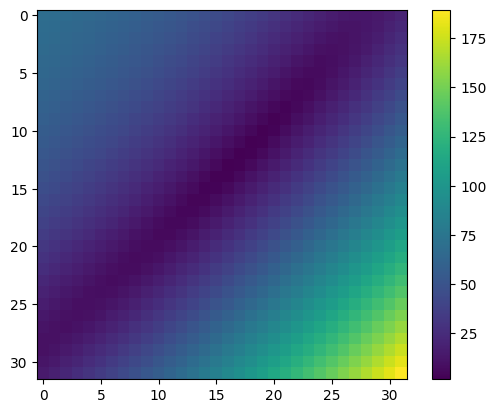

In [45]:
import matplotlib.pyplot as plt 
plt.imshow(residues)
plt.colorbar()

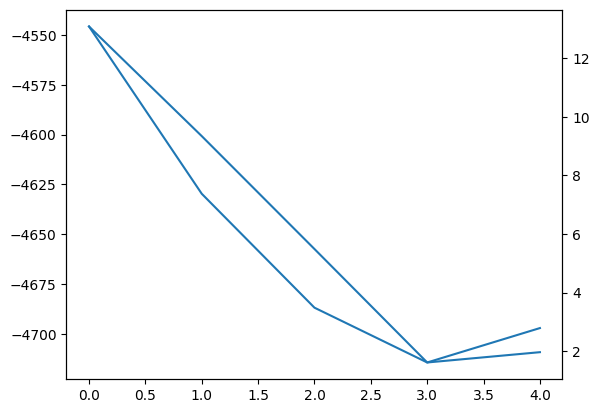

In [57]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() 
idx = 11
ax1.plot(energies[idx,15:20])
ax2.plot(residues[idx, 15:20])

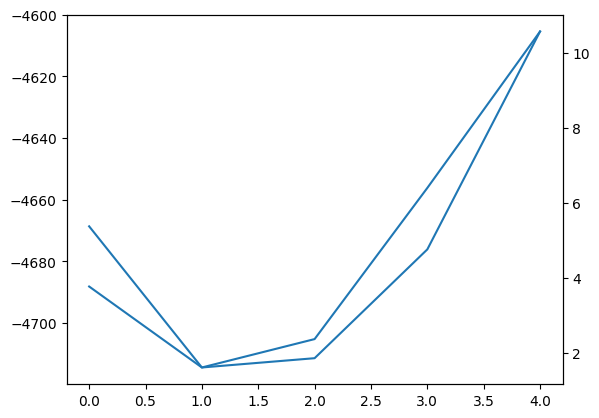

In [59]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() 
idx = 18
ax1.plot(energies[10:15,18])
ax2.plot(residues[10:15, 18])

In [27]:
ref_sol = [2, 3]
trial_sol = [5.16, 1.33]
data_ref, eref = qubo.compute_energy(ref_sol, bqm)
data_sol, esol = qubo.compute_energy(trial_sol, bqm)

print('ref: ', ref_sol, '->', data_ref[0], ' energy: ', eref)
print('sol: ', trial_sol, '->', data_sol[0], ' energy: ', esol)
print(np.array(ref_sol) - np.array(trial_sol))

ref:  [2, 3] -> [2.0, 3.0]  energy:  -636.9999999990687
sol:  [5.16, 1.33] -> [5.2, 1.4]  energy:  1522.8207999998704
[-3.16  1.67]


In [28]:
sampleset.lowest().record[0][1]

-636.9999999031425